# Project: Lobbyists4America Twitter Dataset Analysis
## SQL For Data Science
### By Prateek Shekhar | October 11, 2023
Lobbyists4America is a company that seeks to provide insights to their customers (who aim to affect legislation within the US).  They want you to analyse the 2008-2017 congressional tweets in order to understand key topics, members, and relationships within Congress. These insights will help them focus and strengthen their lobbying efforts.

# Selection Criteria for Client:
I wanted to work for this fictional client and with this dataset for a few reasons. First, I have not encountered social media data like tweets or posts so far in my personal projects. Being able to analyse and work with data from social media is vital for any Data Analyst or Scientist. 

Furthermore, this is an open-ended project where the business questions are not immediately obvious. It is not initially clear where the data can lead us and this makes it more challenging and rewarding to glean insights from this data. 

Finally, upon downloading the dataset, I realized it is JSON data and has some columns that have a lot of information. This closely resembles real-world data and this gives me opportunity to practice some new techniques and python libraries.

In [1]:
#Import the necessary libraries
import numpy as np
import pandas as pd
import json
import re
import datetime
from datetime import datetime as dt
from matplotlib import pyplot as plt
import sqlite3
from pandasql import sqldf

In [2]:
pd.set_option('display.max_rows', 11)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

## Task 1: Cleaning the Data
The following steps are performed to clean the data and prepare it before it is stored as SQLite3 Tables.

*Users Table:*
1. The timestamps in the user JSON table as in POSIX format. These are converted to a proper format.
2. The locations in the user JSON table do not have consistency. For example: Washington is listed as both Washington, D.C. and Washington, DC. I will scrape States, their Capitals, their Abbreviations, and Populations from Wikipedia using BeautifulSoup. Then I will create a new column called Population Percentage which lists this population as a percentage of the total population. This table will be stored as its own States table, but more importantly, there will be a new Table in Users table called States which will correctly indicate the user's state in a consistent format.
3. The entities column for the user Table holds the URL for the user. This column is in JSON format. I will extract the website URLs from this column into a new column called Website.
4. I will then store only the required columns into the users table.

*Tweets Table:*
1. The entities column in the tweets JSON table contains entries in JSON format that contain the hashtags and user mentions in the tweet, if applicable. I will extract these hashtags and user mentions and store them in their own tables.
2. The tweets table contains tweet source in HTML format tags. I will extract the tweet source using BeautifulSoup and place it into its own column. 
3. I will then store only the required columns into the tweets table.


In [3]:
#Read the users data frame. Do not convert dates as they are in POSIX format
users_df = pd.read_json('users.json', lines=True, convert_dates=False)
users_df.head(2)

contributors_enabled  created_at  default_profile  default_profile_image  \
0                 False  1417384037             True                  False   
1                 False  1240239576            False                  False   

                                                                                                                                                       description  \
0  Official Twitter page of Alaska Governor Bill Walker; honored to serve AK w/ @LtGovMallott. RTs ≠ endorsements.Tweets signed "-BW" come directly from Governor.   
1                                                                                            U.S. Senator from Minnesota. Follows, Retweets, Replies ≠ endorsement   

                                                                                                                                                                                    entities  \
0          {'description': {'urls': []}, 'url': {'urls': [{'display_url': 'gov.alaska.gov', 'expanded_url': 'http://gov.alaska.gov', 'indices': [0, 22], 'url': 'http://t.co/NO67LyZvUR'}]}}   
1  {'description': {'urls': []}, 'url': {'urls': [{'display_url': 'amyklobuchar.com', 'expanded_url': 'http://www.amyklobuchar.com', 'indices': [0, 22], 'url': 'http://t.co/mGGFBfggto'}]}}   

   favourites_count  follow_request_sent  followers_count  following  \
0               115                False             5870      False   
1                24                False           170717      False   

   friends_count  geo_enabled  has_extended_profile          id      id_str  \
0            550         True                 False  2915095729  2915095729   
1          91751        False                 False    33537967    33537967   

   is_translation_enabled  is_translator lang  listed_count location  \
0                   False          False   en           190   Alaska   
1                   False          False   en          2493            

                   name  notifications profile_background_color  \
0  Governor Bill Walker          False                   C0DEED   
1         Amy Klobuchar          False                   026113   

                       profile_background_image_url  \
0  http://abs.twimg.com/images/themes/theme1/bg.png   
1  http://abs.twimg.com/images/themes/theme1/bg.png   

                  profile_background_image_url_https  profile_background_tile  \
0  https://abs.twimg.com/images/themes/theme1/bg.png                    False   
1  https://abs.twimg.com/images/themes/theme1/bg.png                    False   

                                            profile_banner_url  \
0  https://pbs.twimg.com/profile_banners/2915095729/1417385137   
1                                                          NaN   

                                                            profile_image_url  \
0  http://pbs.twimg.com/profile_images/737753674466787329/rmi2xV_E_normal.jpg   
1       http://pbs.twimg.com/profile_images/1815362035/AJK_Twitter_normal.jpg   

                                                       profile_image_url_https  \
0  https://pbs.twimg.com/profile_images/737753674466787329/rmi2xV_E_normal.jpg   
1       https://pbs.twimg.com/profile_images/1815362035/AJK_Twitter_normal.jpg   

  profile_link_color profile_sidebar_border_color profile_sidebar_fill_color  \
0             1DA1F2                       C0DEED                     DDEEF6   
1             026113                       F6D73F                     89BCEE   

  profile_text_color  profile_use_background_image  protected  \
0             333333                          True      False   
1             3D3C3D                          True      False   

       screen_name  statuses_count                   time_zone  \
0  AkGovBillWalker            1642                        None   
1     amyklobuchar            5567  Central Time (US & Canada)   

  translator_type                     url  utc_offset  verified  
0            

In [4]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   contributors_enabled                548 non-null    bool   
 1   created_at                          548 non-null    object 
 2   default_profile                     548 non-null    bool   
 3   default_profile_image               548 non-null    bool   
 4   description                         548 non-null    object 
 5   entities                            545 non-null    object 
 6   favourites_count                    548 non-null    int64  
 7   follow_request_sent                 548 non-null    bool   
 8   followers_count                     548 non-null    int64  
 9   following                           548 non-null    bool   
 10  friends_count                       548 non-null    int64  
 11  geo_enabled                         548 non-n

In [5]:
#Our created_at column contains different formats, both Unix timestamps as well as other formats. 
#Convert everything into a Unix format
#Then convert it to Int
#Then apply UTC conversion to get proper timestamp

def convert_to_unix_int(timestamp_str):
    try:
        # Attempt to convert as an integer (Unix timestamp)
        return int(timestamp_str)
    except ValueError:
        try:
            # Attempt to parse the different format
            timestamp = dt.strptime(timestamp_str, '%a %b %d %H:%M:%S %z %Y')
            return int(timestamp.timestamp())
        except ValueError:
            # Handle any other cases or return None for unsupported formats
            return None

# Apply the conversion function to the 'created_at' column
users_df['created_at'] = users_df['created_at'].apply(convert_to_unix_int)

# Now, the 'created_at' column contains Unix timestamps where possible
#Apply lambda function to convert to UTC Timestamp
users_df['created_at'] = users_df['created_at'].apply(lambda x: dt.utcfromtimestamp(x))
users_df.head(2)

contributors_enabled          created_at  default_profile  \
0                 False 2014-11-30 21:47:17             True   
1                 False 2009-04-20 14:59:36            False   

   default_profile_image  \
0                  False   
1                  False   

                                                                                                                                                       description  \
0  Official Twitter page of Alaska Governor Bill Walker; honored to serve AK w/ @LtGovMallott. RTs ≠ endorsements.Tweets signed "-BW" come directly from Governor.   
1                                                                                            U.S. Senator from Minnesota. Follows, Retweets, Replies ≠ endorsement   

                                                                                                                                                                                    entities  \
0          {'description': {'urls': []}, 'url': {'urls': [{'display_url': 'gov.alaska.gov', 'expanded_url': 'http://gov.alaska.gov', 'indices': [0, 22], 'url': 'http://t.co/NO67LyZvUR'}]}}   
1  {'description': {'urls': []}, 'url': {'urls': [{'display_url': 'amyklobuchar.com', 'expanded_url': 'http://www.amyklobuchar.com', 'indices': [0, 22], 'url': 'http://t.co/mGGFBfggto'}]}}   

   favourites_count  follow_request_sent  followers_count  following  \
0               115                False             5870      False   
1                24                False           170717      False   

   friends_count  geo_enabled  has_extended_profile          id      id_str  \
0            550         True                 False  2915095729  2915095729   
1          91751        False                 False    33537967    33537967   

   is_translation_enabled  is_translator lang  listed_count location  \
0                   False          False   en           190   Alaska   
1                   False          False   en          2493            

                   name  notifications profile_background_color  \
0  Governor Bill Walker          False                   C0DEED   
1         Amy Klobuchar          False                   026113   

                       profile_background_image_url  \
0  http://abs.twimg.com/images/themes/theme1/bg.png   
1  http://abs.twimg.com/images/themes/theme1/bg.png   

                  profile_background_image_url_https  profile_background_tile  \
0  https://abs.twimg.com/images/themes/theme1/bg.png                    False   
1  https://abs.twimg.com/images/themes/theme1/bg.png                    False   

                                            profile_banner_url  \
0  https://pbs.twimg.com/profile_banners/2915095729/1417385137   
1                                                          NaN   

                                                            profile_image_url  \
0  http://pbs.twimg.com/profile_images/737753674466787329/rmi2xV_E_normal.jpg   
1       http://pbs.twimg.com/profile_images/1815362035/AJK_Twitter_normal.jpg   

                                                       profile_image_url_https  \
0  https://pbs.twimg.com/profile_images/737753674466787329/rmi2xV_E_normal.jpg   
1       https://pbs.twimg.com/profile_images/1815362035/AJK_Twitter_normal.jpg   

  profile_link_color profile_sidebar_border_color profile_sidebar_fill_color  \
0             1DA1F2                       C0DEED                     DDEEF6   
1             026113                       F6D73F                     89BCEE   

  profile_text_color  profile_use_background_image  protected  \
0             333333                          True      False   
1             3D3C3D                          True      False   

       screen_name  statuses_count                   time_zone  \
0  AkGovBillWalker            1642                        None   
1     amyklobuchar            5567  Central Time (US & Canada)   

  translator_type                     u

#### ** The dates are now in correct format

In [6]:
pd.set_option('display.max_rows', None)  # Set the maximum rows to display
users_df['location'].value_counts().head()
#TODO: Clean the Location Column so similar cities like Washington, DC and Washington, D.C. are counted as the same cities.

                    134
Washington, DC       24
Washington, D.C.      7
Oklahoma              4
Oregon                4
Name: location, dtype: int64

In [7]:
#Let us scrape State information from Wikipedia
#We are going to store 5 columns - State, State Abbreviation, Population, Population Percentage, Abbreviation
#Import beautiful soup for scraping
import requests
from bs4 import BeautifulSoup

# The URL of the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States"

# Send an HTTP GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the HTML content of the page
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table containing the list of states and territories
    table = soup.find('table', {'class': 'wikitable'})

    if table:
        # Initialize lists to store the state names and cities
        state_names = []
        state_abbr = []
        state_cap = []
        state_pop = []
        

        # Find all rows in the table (skip the header row)
        rows = table.find_all('tr')[2:]

        for row in rows:
            # Extract the state name (from the first column)
            state_name = row.find('th').text.strip()
            if '[B]' in state_name:
                cleaned_name = state_name.replace('[B]', '')
            else:
                cleaned_name = state_name
                
            
            #Extract the abbreviation of the state
            abbr = row.find('td').text.strip()

            # Extract the list of cities (from the second column, if available)
            city_column = row.find_all('td')
            city_names = city_column[1].text.strip()

                
            # Extract population from fourth column (from the second column, if available)
            pop_column = row.find_all('td')
            pop_num = pop_column[-8].text.strip()


            # Append state name and cities to the respective lists
            state_abbr.append(abbr)
            state_names.append(cleaned_name)
            state_cap.append(city_names)
            population_int = int(pop_num.replace(",", ""))
            state_pop.append(population_int)

    else:
        print("Table not found on the page.")

else:
    print(f"Failed to retrieve the page. Status code: {response.status_code}")
    

state_df = pd.DataFrame ({
    'State':state_names,
    'Abbreviation':state_abbr,
    'Capital':state_cap,
    'Population':state_pop
})
total_population = state_df['Population'].sum()
state_df['Percentage'] = (state_df['Population']/total_population)*100
state_df['Percentage'] = state_df['Percentage'].round(2)
state_df.head()

State Abbreviation      Capital  Population  Percentage
0     Alabama           AL   Montgomery     5024279        1.52
1      Alaska           AK       Juneau      733391        0.22
2     Arizona           AZ      Phoenix     7151502        2.16
3    Arkansas           AR  Little Rock     3011524        0.91
4  California           CA   Sacramento    39538223       11.95

#### ** Scraped Wikipedia and created the State dataframe

In [8]:
#Now we're going to create a new column called States, which will check if each of the States matches 
#the description or location of each User. If it does, it will Place that state's name in the State column
#We will use this column over location for our analysis.
pd.reset_option('display.max_rows')
def find_state(row, states):
    for state in states['State']:
        if state in row['description'] or state in row['location']:
            return state
    for abbr in states['Abbreviation']:
        if abbr in row['description'] or abbr in row['location']:
            return states.loc[states['Abbreviation'] == abbr, 'State'].values[0]
    return None  # Return None if no state match is found

# Apply the find_state function to each row in the 'users' DataFrame and create a 'State' column
users_df['State'] = users_df.apply(find_state, args=(state_df,), axis=1)
users_df['State'].value_counts().head()

California    46
Washington    37
Texas         30
New York      26
Florida       25
Name: State, dtype: int64

#### ** The States column has been added to Users

In [9]:
users_df['entities'][0]
#Exploring the entities column, we see that this column contains the URL for each user
#Hence, we can use the entities column to extract the website for each user.

{'description': {'urls': []},
 'url': {'urls': [{'display_url': 'gov.alaska.gov',
    'expanded_url': 'http://gov.alaska.gov',
    'indices': [0, 22],
    'url': 'http://t.co/NO67LyZvUR'}]}}

In [10]:
#Function to extract the URL from the JSON dictionaries in the entities column in Users table
def extract_website (entities):
    if isinstance (entities, dict):
        try:
            if 'url' in entities and 'urls' in entities['url']:
                urls = entities['url']['urls']
                if urls:
                    website = urls[0]['expanded_url']
                    return website
                
        except KeyError:
            pass
    return None


users_df['website'] = users_df['entities'].apply(extract_website)

In [11]:
users_df['website'].head()
#Now we have websites for each of the users in a separate column.

0               http://gov.alaska.gov
1         http://www.amyklobuchar.com
2         http://www.anthonybrown.com
3    http://www.governor.arkansas.gov
4        http://austinscott.house.gov
Name: website, dtype: object

In [12]:
null_count = users_df['website'].isnull().sum()
print(null_count)
#We have 37 columns as Null

37


#### ** The website column has been added and contains URL for each user. There are 37 users with no website listed

In [13]:
#Storing only the columns we need.
users_df = users_df[['created_at','description','favourites_count','followers_count','friends_count','geo_enabled','id',
                    'listed_count','State','name','screen_name','statuses_count','time_zone','verified','website']]

In [14]:
users_df.head(2)

created_at  \
0 2014-11-30 21:47:17   
1 2009-04-20 14:59:36   

                                                                                                                                                       description  \
0  Official Twitter page of Alaska Governor Bill Walker; honored to serve AK w/ @LtGovMallott. RTs ≠ endorsements.Tweets signed "-BW" come directly from Governor.   
1                                                                                            U.S. Senator from Minnesota. Follows, Retweets, Replies ≠ endorsement   

   favourites_count  followers_count  friends_count  geo_enabled          id  \
0               115             5870            550         True  2915095729   
1                24           170717          91751        False    33537967   

   listed_count      State                  name      screen_name  \
0           190     Alaska  Governor Bill Walker  AkGovBillWalker   
1          2493  Minnesota         Amy Klobuchar     amyklobuchar   

   statuses_count                   time_zone  verified  \
0            1642                        None      True   
1            5567  Central Time (US & Canada)      True   

                       website  
0        http://gov.alaska.gov  
1  http://www.amyklobuchar.com

#### ** The Users table has now been prepped with only the needed columns 

In [17]:
tweets_df = pd.read_json('tweets.json', lines=True)
tweets_df.head(2)

contributors coordinates          created_at display_text_range  \
0           NaN        None 2008-08-04 17:28:51            [0, 74]   
1           NaN        None 2008-08-06 19:04:45            [0, 25]   

                                                           entities  \
0  {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []}   
1  {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []}   

   favorite_count  favorited   geo         id     id_str  \
0               0      False  None  877418565  877418565   
1               0      False  None  879618172  879618172   

  in_reply_to_screen_name  in_reply_to_status_id  in_reply_to_status_id_str  \
0                    None                    NaN                        NaN   
1                    None                    NaN                        NaN   

   in_reply_to_user_id  in_reply_to_user_id_str  is_quote_status lang place  \
0                  NaN                      NaN            False   en  None   
1                  NaN                      NaN            False   nl  None   

   retweet_count  retweeted  screen_name  \
0              0      False  JohnBoozman   
1              0      False  JohnBoozman   

                                                               source  \
0  <a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>   
1  <a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>   

                                                                         text  \
0  On a conference call about a weekend trip to Iraq to visit Arkansas troops   
1                                                   Being interviewed by KTHV   

   truncated  user_id  possibly_sensitive extended_entities  quoted_status_id  \
0      False  5558312                 NaN               NaN               NaN   
1      False  5558312                 NaN               NaN               NaN   

   quoted_status_id_str  withheld_copyright withheld_in_countries  \
0                   NaN                 NaN                   NaN   
1                   NaN                 NaN                   NaN   

  withheld_scope  
0            NaN  
1            NaN

In [18]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243370 entries, 0 to 1243369
Data columns (total 32 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   contributors               0 non-null        float64       
 1   coordinates                2734 non-null     object        
 2   created_at                 1243370 non-null  datetime64[ns]
 3   display_text_range         1243370 non-null  object        
 4   entities                   1243370 non-null  object        
 5   favorite_count             1243370 non-null  int64         
 6   favorited                  1243370 non-null  bool          
 7   geo                        2734 non-null     object        
 8   id                         1243370 non-null  int64         
 9   id_str                     1243370 non-null  int64         
 10  in_reply_to_screen_name    65411 non-null    object        
 11  in_reply_to_status_id      54146 non-

In [19]:
#Extracting Hashtags from the entities column and saving it as a dataframe hashtags_df
hashtags_data=[]
for index, row in tweets_df.iterrows():
    entities = row['entities']
    hashtags = entities['hashtags']
    tweet_id = row['id_str']
    for hashtag in hashtags:
        hashtags_data.append({'tweet_id': tweet_id, 'hashtag': hashtag['text']})

hashtags_df = pd.DataFrame(hashtags_data)
hashtags_df['hashtag'].value_counts().head()

Obamacare    11124
tcot          8010
ACA           6168
SOTU          5967
SCOTUS        4934
Name: hashtag, dtype: int64

#### ** Hashtags have been extracted from entities column and Hashtag dataframe created

In [20]:
#Extracting User Mentions from the entities column and saving it as a dataframe mentions_df
mentions_data=[]
for index, row in tweets_df.iterrows():
    entities = row['entities']
    user_mentions = entities['user_mentions']
    tweet_id = row['id_str']
    for mention in user_mentions:
        mentions_data.append({'tweet_id': tweet_id, 'user_mention': mention['name']})

mentions_df = pd.DataFrame(mentions_data)
mentions_df['user_mention'].value_counts().head()

President Trump      14232
House Republicans    11003
Donald J. Trump       6968
Paul Ryan             5774
John Boehner          4502
Name: user_mention, dtype: int64

#### ** User Mentions have been extracted from entities column and Mention dataframe created

In [21]:
#Get tweet source text without HTML tags
def extract_text_from_html(html):
    soup = BeautifulSoup(html, 'html.parser')
    return soup.get_text()

tweets_df['source_text'] = tweets_df['source'].apply(extract_text_from_html)
tweets_df['source_text'].value_counts().head()

Twitter Web Client    563425
TweetDeck             255174
Twitter for iPhone    248476
Hootsuite              47142
Facebook               18275
Name: source_text, dtype: int64

#### ** Source text column has been created

In [22]:
tweets_df = tweets_df[['created_at','user_id','display_text_range','favorite_count','favorited','id','id_str',
             'in_reply_to_screen_name','in_reply_to_status_id','in_reply_to_status_id_str','in_reply_to_user_id',
             'in_reply_to_user_id_str','is_quote_status','retweet_count','screen_name','source_text','text']]
tweets_df.rename(columns={'id_str': 'tweet_id'}, inplace=True)

#### ** The Tweets table has now been prepped with only the needed columns 

## Task 2: Creating SQL database and Tables
The following ERD is being used to create our database
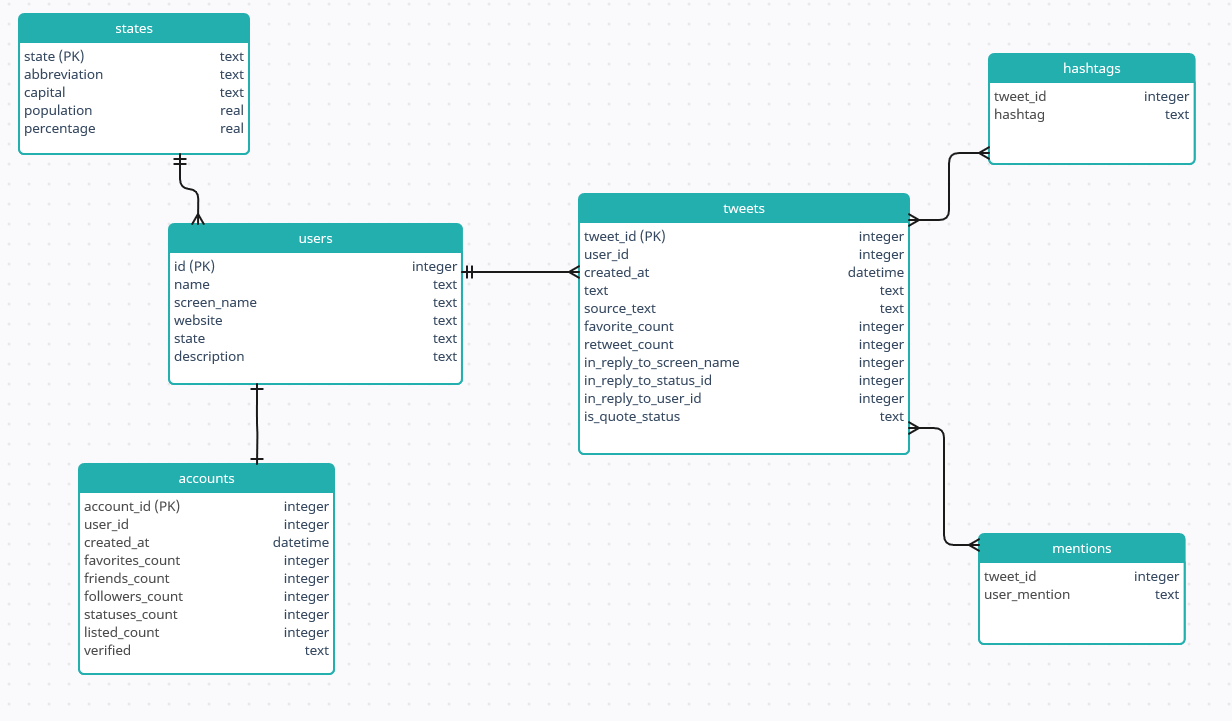
*users Table:*
This is a table that contains information about the users. It has a one-to-one relationship with the accounts table and a one-to-many relationship with the tweets table (as one user can have multiple tweets).

*tweets Table:*
This is a table that contains information about each tweet. It has many-to-many relationships with hashtags table and mentions table, which are lookup tables for user mentions and tweet hashtags.

*accounts Table:*
This is a table that contains information about each account. This is a separate table from users as the information in the accounts table is more likely to update frequently over information in the users table (like likes and followers)

*states Table:*
The states table is a state lookup table that has information about the states. It has a one-to-many relationship with the users table as each user only has one state but multiple users can have the same state.

*hashtags Table:*
Lookup table for tweet hashtags.

*mentions Table:*
Lookup table for user mentions in tweets.


In [23]:
con = sqlite3.connect("twitter.db")
cur = con.cursor()

In [24]:
cur.execute("DROP TABLE IF EXISTS states")
cur.execute("DROP TABLE IF EXISTS users")
cur.execute("DROP TABLE IF EXISTS accounts")
cur.execute("DROP TABLE IF EXISTS tweets")

In [25]:
cur.execute("""CREATE TABLE IF NOT EXISTS states (
                    state                               TEXT PRIMARY KEY NOT NULL,
                    abbreviation                        TEXT,
                    capital                             TEXT,
                    population                          REAL,
                    percentage                          REAL
                    )""")
state_df.to_sql('states', con, if_exists='replace', index = False)

50

In [26]:
cur.execute("""CREATE TABLE IF NOT EXISTS users (
                    id                          INTEGER PRIMARY KEY NOT NULL,
                    name                        TEXT,
                    screen_name                 TEXT,
                    website                     TEXT,
                    state                       TEXT,
                    description                 TEXT
                    )""")
users_sql_df = users_df[['id','name','screen_name','website','State','description']]
users_sql_df.to_sql('users', con, if_exists='replace', index = False)

548

In [27]:
cur.execute("""CREATE TABLE IF NOT EXISTS accounts (
                    account_id                  INTEGER PRIMARY KEY NOT NULL,
                    user_id                     INTEGER,
                    created_at                  DATETIME,
                    favorites_count             INTEGER,
                    friends_count               INTEGER,
                    followers_count             INTEGER,
                    statuses_count              INTEGER,
                    listed_count                INTEGER,
                    verified                    TEXT
                    )""")

In [28]:
for index, row in users_df.iterrows():
    # Extract values from the DataFrame row
    user_id = row['id']
    created_at = row['created_at'].strftime('%Y-%m-%d %H:%M:%S')
    favorites_count = row['favourites_count']
    friends_count = row['friends_count']
    followers_count = row['followers_count']
    statuses_count = row['statuses_count']
    listed_count = row['listed_count']
    verified = row['verified']

    # Insert the values into the "accounts" table
    cur.execute("INSERT INTO accounts (user_id, created_at, favorites_count, friends_count, followers_count, statuses_count, listed_count, verified) VALUES (?, ?, ?, ?, ?, ?, ?, ?)",
                   (user_id, created_at, favorites_count, friends_count, followers_count, statuses_count, listed_count, verified))

In [29]:
cur.execute("""CREATE TABLE IF NOT EXISTS tweets (
                    tweet_id                    INTEGER PRIMARY KEY NOT NULL,
                    user_id                     INTEGER,
                    created_at                  DATETIME,
                    content                     TEXT,
                    source                      TEXT,
                    favorite_count              INTEGER,
                    retweet_count               INTEGER,
                    in_reply_to_screen_name     INTEGER,
                    in_reply_to_status_id       INTEGER,
                    in_reply_to_user_id         INTEGER,
                    is_quote_status             TEXT
                    )""")

tweets_sql_df = tweets_df[['tweet_id','user_id','created_at','text','source_text','favorite_count','retweet_count','in_reply_to_screen_name','in_reply_to_status_id','in_reply_to_user_id','is_quote_status']]
tweets_sql_df.to_sql('tweets', con, if_exists='replace', index = False)

1243370

In [30]:
cur.execute("""CREATE TABLE IF NOT EXISTS hashtags (
                    tweet_id                    INTEGER,
                    hashtag                     TEXT,
                    PRIMARY KEY (tweet_id, hashtag)
                    )""")

hashtags_df.to_sql('hashtags', con, if_exists='replace', index = False)

906530

In [31]:
cur.execute("""CREATE TABLE IF NOT EXISTS mentions (
                    tweet_id                    INTEGER,
                    user_mention                TEXT,
                    PRIMARY KEY (tweet_id, user_mention)
                    )""")

mentions_df.to_sql('mentions', con, if_exists='replace', index = False)

1018660

#### ** The required SQL tables have been created and information entered into them. Now we can query them using SQL statements 

## Task 3: Exploratory Data Analysis and Visualizations
We shall now conduct some EDA and prepare visualizations and see if our hypothesis is supported by some insights we gain from these visualizations.

### Initial Hypotheses:
1. Users that live in densely populated states are more likely to have more followers. The higher the population of a state, the more twitter users that state may have, and consequently, the representatives in those states may have more followers compared to representatives from smaller states.
2. Newly created accounts are likely to have fewer followers than older accounts who have had more time to accrue followers.
3. Accounts that have a high number of tweets are more likely to have more followers than accounts with fewer tweets.

In [32]:
res = cur.execute ("""SELECT u.name AS Name,
                           a.created_at AS Date,
                           a.followers_count AS followers,
                           u.state AS state,
                           s.population AS population,
                           a.statuses_count AS tweets,
                           a.favorites_count AS times_favorited,
                           a.friends_count AS following,
                           a.listed_count AS times_listed
                    FROM users u JOIN accounts a ON u.id = a.user_id
                    JOIN states s ON u.state = s.state """)

fvS_df = pd.DataFrame(res.fetchall())
fvS_df.columns = ['Name', 'Date Created','Followers','State Name', 'State Population','Number of Tweets','Times Favorited','Accounts Following','Times Listed']
fvS_df['Year of Creation'] =  pd.to_datetime(fvS_df['Date Created']).dt.year
fvS_df.head(2)

Name         Date Created  Followers State Name  \
0  Governor Bill Walker  2014-11-30 21:47:17       5870     Alaska   
1         Amy Klobuchar  2009-04-20 14:59:36     170717  Minnesota   

   State Population  Number of Tweets  Times Favorited  Accounts Following  \
0            733391              1642              115                 550   
1           5706494              5567               24               91751   

   Times Listed  Year of Creation  
0           190              2014  
1          2493              2009

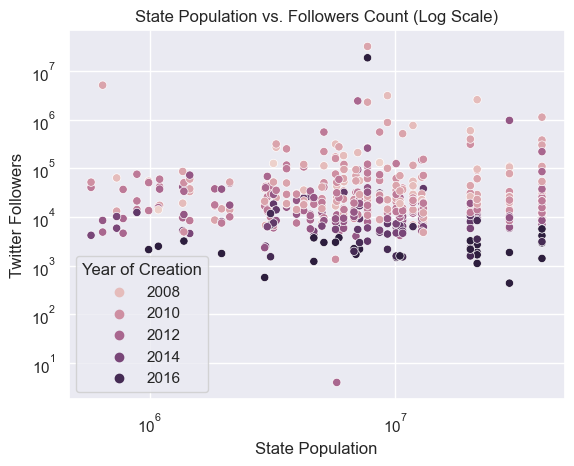

In [33]:
import seaborn as sns
sns.set_theme()
sns.set_style("darkgrid")

sns.scatterplot(x='State Population', y='Followers',hue='Year of Creation', data=fvS_df)
plt.xlabel("State Population")
plt.ylabel("Twitter Followers")
plt.title("State Population vs. Followers Count (Log Scale)")
plt.xscale('log')
plt.yscale('log')

# Show the plot
plt.show()

In [34]:
correlation = fvS_df['State Population'].corr(fvS_df['Followers'])

# Print the correlation coefficient
print("Pearson's correlation coefficient:", correlation)

Pearson's correlation coefficient: -0.025451879735959665


### Takeaway:
The data does not indicate a strong correlation between the state population and the number of followers. Hence, our initial hypothesis has been debunked.

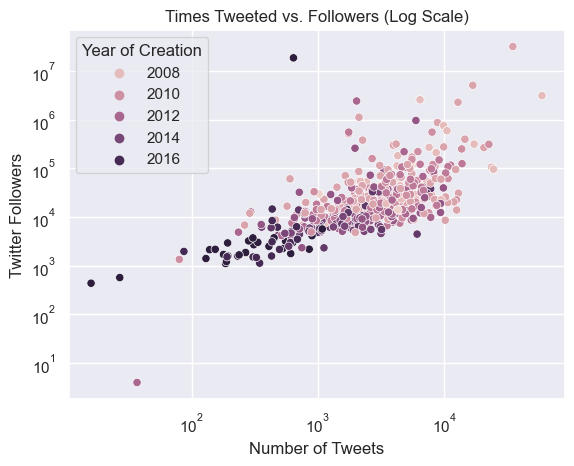

In [35]:
sns.scatterplot(x='Number of Tweets', y='Followers',hue='Year of Creation', data=fvS_df)

# Set labels and a title
plt.xlabel("Number of Tweets")
plt.ylabel("Twitter Followers")
plt.title("Times Tweeted vs. Followers (Log Scale)")
plt.xscale('log')
plt.yscale('log')

# Show the plot
plt.show()

In [36]:
correlation = fvS_df['Number of Tweets'].corr(fvS_df['Followers'])

# Print the correlation coefficient
print("Pearson's correlation coefficient:", correlation)

Pearson's correlation coefficient: 0.3391730745228367


### Takeaway:
The date indicates a moderately strong correlation between the number of tweets and the number of followers. We also notice that older accounts have more tweets and newer accounts have less tweets. Hence, it is not clear whether the increased followers are due to the account being older or because of the high tweet count or a combination of both.

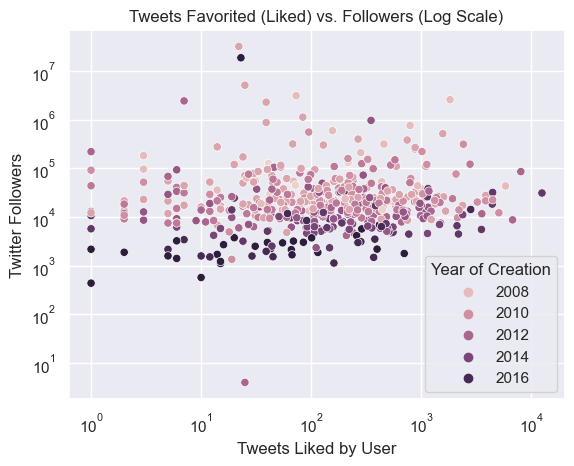

In [37]:
sns.scatterplot(x='Times Favorited', y='Followers',hue='Year of Creation', data=fvS_df)

# Set labels and a title
plt.xlabel("Tweets Liked by User")
plt.ylabel("Twitter Followers")
plt.title("Tweets Favorited (Liked) vs. Followers (Log Scale)")
plt.xscale('log')
plt.yscale('log')

# Show the plot
plt.show()

In [38]:
correlation = fvS_df['Times Favorited'].corr(fvS_df['Followers'])

# Print the correlation coefficient
print("Pearson's correlation coefficient:", correlation)

Pearson's correlation coefficient: -0.025044552073006324


### Takeaway:
The number of tweets an account likes has no bearing on the number of followers.

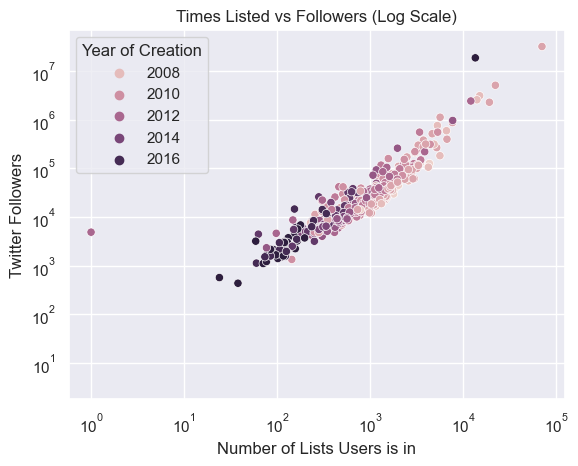

In [39]:
sns.scatterplot(x='Times Listed', y='Followers',hue='Year of Creation', data=fvS_df)

# Set labels and a title
plt.xlabel("Number of Lists Users is in")
plt.ylabel("Twitter Followers")
plt.title("Times Listed vs Followers (Log Scale)")
plt.xscale('log')
plt.yscale('log')

# Show the plot
plt.show()

In [40]:
correlation = fvS_df['Times Listed'].corr(fvS_df['Followers'])

# Print the correlation coefficient
print("Pearson's correlation coefficient:", correlation)

Pearson's correlation coefficient: 0.8797520692922193


### Takeaway:
There is a very strong correlation between the amount of lists an account has been added to versus the number of twitter followers. So far this is the strongest metric that determines the number of followers an account would have.

In [41]:
res = cur.execute ("""SELECT u.name AS Name,
                           a.followers_count AS Followers,
                           SUM(t.favorite_count + t. retweet_count) AS virality
                    FROM tweets t
                    JOIN users u
                    ON t.user_id = u.id
                    JOIN accounts a
                    ON a.user_id = t.user_id
                    GROUP BY u.name
                    ORDER BY virality DESC""")
vir_df = pd.DataFrame(res.fetchall())
vir_df.columns = ['Name','Followers','Virality (Retweets+Likes)']
vir_df.head()

Name  Followers  Virality (Retweets+Likes)
0   Donald J. Trump   31712585                  178628324
1    Bernie Sanders    5072538                   46371460
2   President Trump   18545354                   15415791
3  Elizabeth Warren    2412087                   11862249
4       Adam Schiff     298997                    7576164

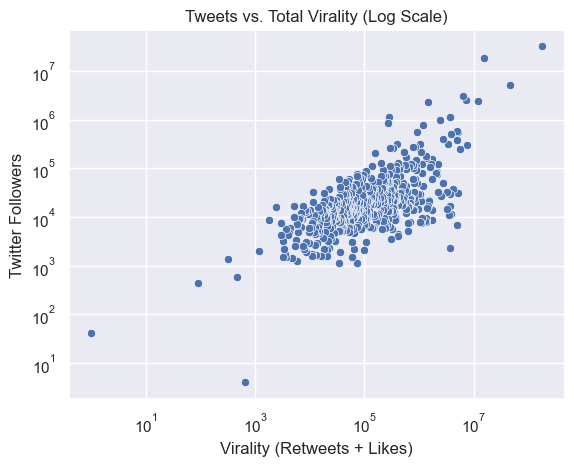

In [42]:
sns.scatterplot(x='Virality (Retweets+Likes)', y='Followers', data=vir_df)

# Set labels and a title
plt.xlabel("Virality (Retweets + Likes)")
plt.ylabel("Twitter Followers")
plt.title("Tweets vs. Total Virality (Log Scale)")
plt.xscale('log')
plt.yscale('log')

# Show the plot
plt.show()

In [43]:
correlation = vir_df['Virality (Retweets+Likes)'].corr(vir_df['Followers'])

# Print the correlation coefficient
print("Pearson's correlation coefficient:", correlation)

Pearson's correlation coefficient: 0.8933658126015037


### Takeaway:
We have created a new feature called Virality which is the total number of retweets and likes an account's tweets have. This shows a very strong correlation with the amount of followers an account has. However, this does not give us much insight as accounts with high number of followers are more likely to have tweets that go viral. 

## Task 5: Deeper Analysis


## Most tweeted about Words & Word Cloud:
I am going to use ntlk to clean the text in the tweets and remove the stop words from the tweets. Then I'm going to analyze the remaining text to get the most common tweeted about terms by year. I will then create a word cloud and a table to visualize the most common words by year.

In [44]:
res = cur.execute ("""SELECT u.name AS Name,
                           u.screen_name AS screen_name,
                           t.text AS tweet_text,
                           t.created_at AS tweet_date,
                           t.source_text AS tweet_source
                    FROM tweets t
                    JOIN users u
                    ON t.user_id = u.id""")
tweet_text_df = pd.DataFrame(res.fetchall())
tweet_text_df.columns = ['Name','Screen Name','Tweet Text','Date','Tweet Source']
tweet_text_df.head()

Name  Screen Name  \
0  Senator John Boozman  JohnBoozman   
1  Senator John Boozman  JohnBoozman   
2  Senator John Boozman  JohnBoozman   
3  Senator John Boozman  JohnBoozman   
4  Senator John Boozman  JohnBoozman   

                                                                                   Tweet Text  \
0                  On a conference call about a weekend trip to Iraq to visit Arkansas troops   
1                                                                   Being interviewed by KTHV   
2                           Being interviewed by KARN on his Arkansas World Trade Center trip   
3                                                       On KWHN in Fort Smith, that's 1320 AM   
4  Attending a Military of the Purple Heart Ceremony at the VA Medical Center in Fayetteville   

                  Date        Tweet Source  
0  2008-08-04 17:28:51  Twitter Web Client  
1  2008-08-06 19:04:45  Twitter Web Client  
2  2008-08-06 20:35:36  Twitter Web Client  
3  2008-08-07 13:52:52  Twitter Web Client  
4  2008-08-07 15:12:05  Twitter Web Client

In [45]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [46]:
#Add a new column called Tweet Text Clean that includes the Tweet Text without special characters, and everything in lowercase
tweet_text_df['Tweet Text Clean'] = tweet_text_df['Tweet Text'].apply(
    lambda x: re.sub(r'[^a-zA-Z\s]', '', x.lower())
)
tweet_text_df.head(2)

Name  Screen Name  \
0  Senator John Boozman  JohnBoozman   
1  Senator John Boozman  JohnBoozman   

                                                                   Tweet Text  \
0  On a conference call about a weekend trip to Iraq to visit Arkansas troops   
1                                                   Being interviewed by KTHV   

                  Date        Tweet Source  \
0  2008-08-04 17:28:51  Twitter Web Client   
1  2008-08-06 19:04:45  Twitter Web Client   

                                                             Tweet Text Clean  
0  on a conference call about a weekend trip to iraq to visit arkansas troops  
1                                                   being interviewed by kthv

#### ** Text has been transformed to lowercase and all special characters have been removed

In [47]:
#Add a new column called Text Without Stop Words that removes most common words in tweets that are not important to us.
stop_words = set(stopwords.words('english') + ['attending', 'thank', 'today', 'rt', 'amp', 'great', 'new', 'need','thanks',
                                               'u','https','http','w','video','day'])
tweet_text_df['Text Without Stop Words'] = tweet_text_df['Tweet Text Clean'].apply(
    lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words])
)
tweet_text_df.head(2)

Name  Screen Name  \
0  Senator John Boozman  JohnBoozman   
1  Senator John Boozman  JohnBoozman   

                                                                   Tweet Text  \
0  On a conference call about a weekend trip to Iraq to visit Arkansas troops   
1                                                   Being interviewed by KTHV   

                  Date        Tweet Source  \
0  2008-08-04 17:28:51  Twitter Web Client   
1  2008-08-06 19:04:45  Twitter Web Client   

                                                             Tweet Text Clean  \
0  on a conference call about a weekend trip to iraq to visit arkansas troops   
1                                                   being interviewed by kthv   

                                   Text Without Stop Words  
0  conference call weekend trip iraq visit arkansas troops  
1                                         interviewed kthv

#### ** Stop words have been removed from the text.

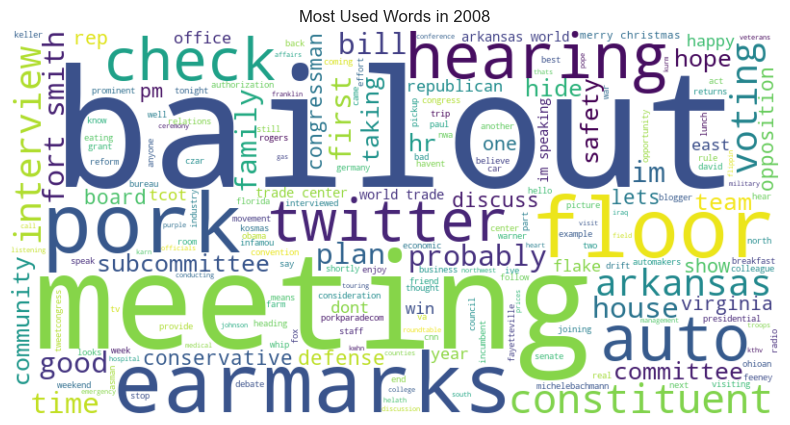

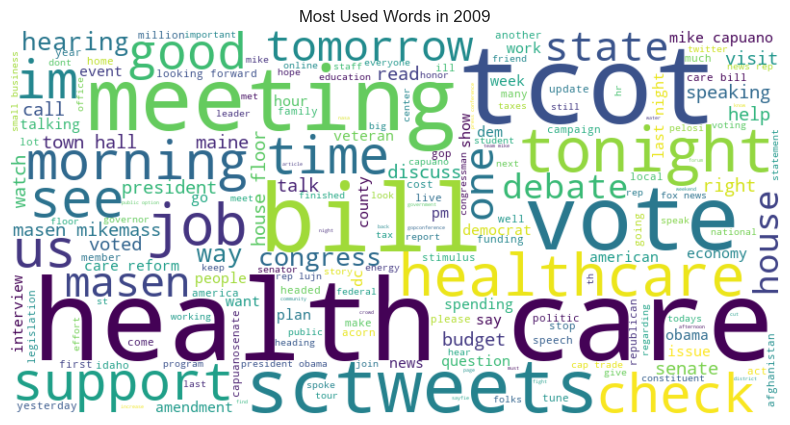

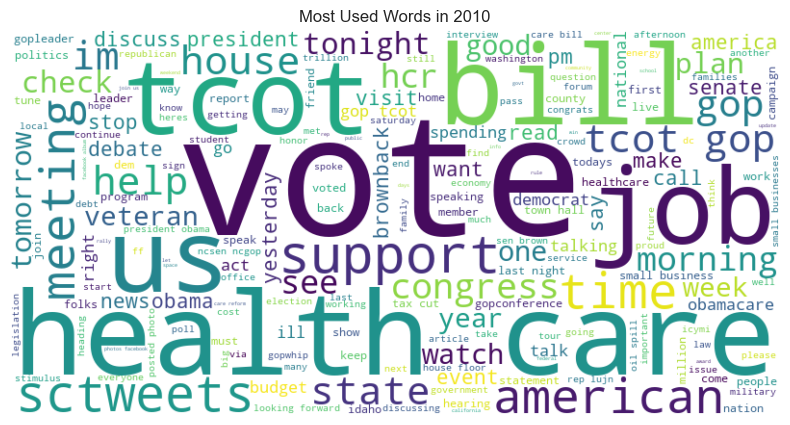

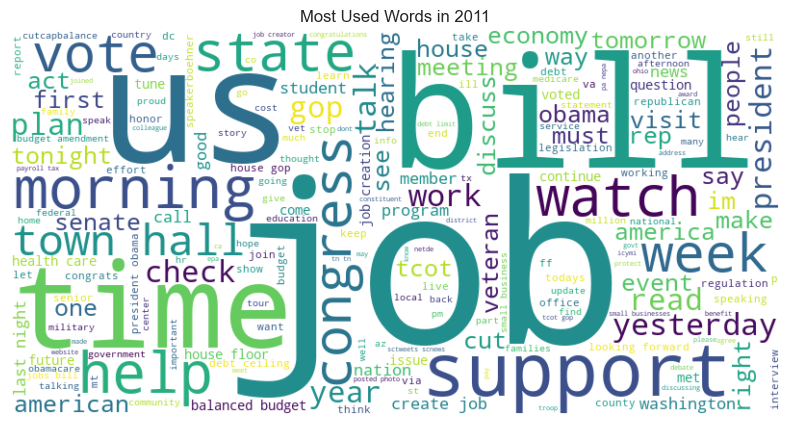

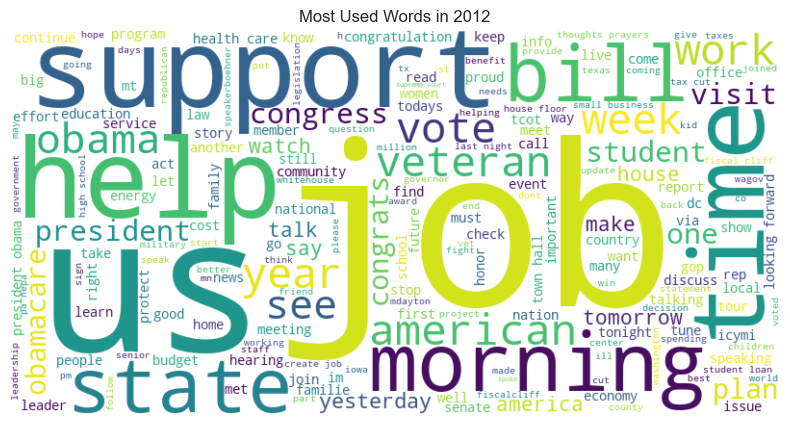

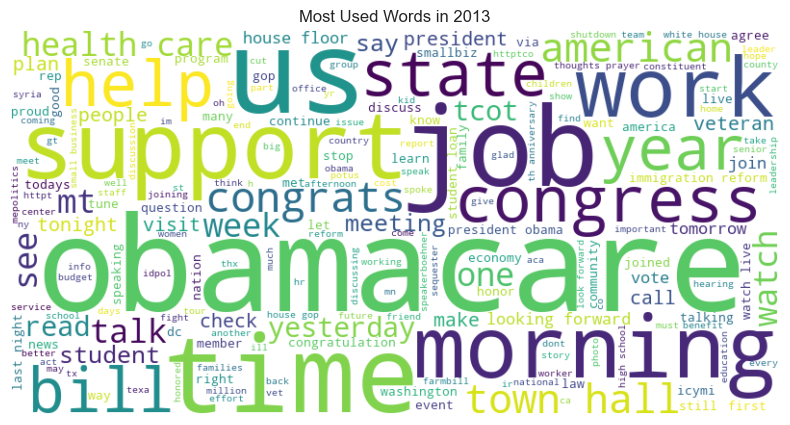

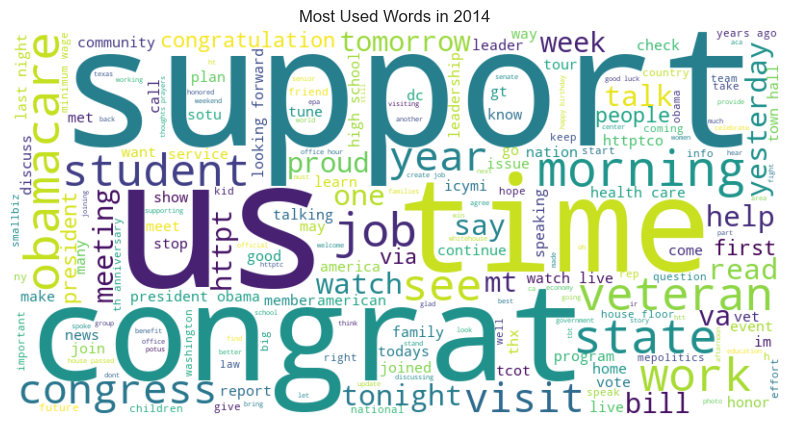

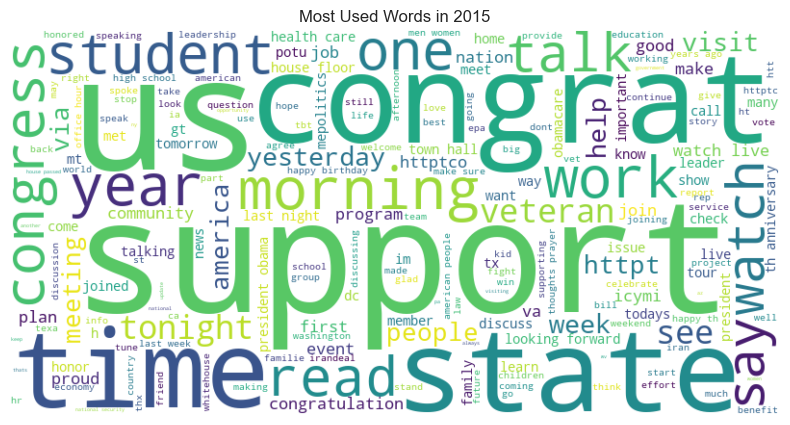

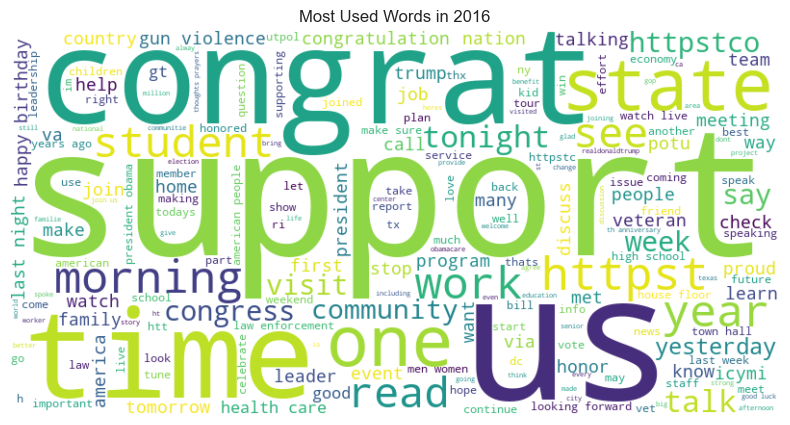

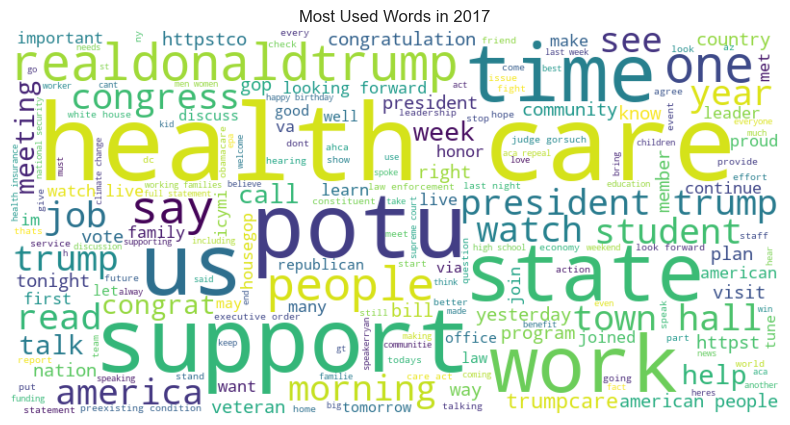

In [48]:
# Task 3: Create wordclouds based on each year
years = pd.to_datetime(tweet_text_df['Date']).dt.year.unique()

for year in years:
    text_year = tweet_text_df[tweet_text_df['Date'].str.contains(str(year))]
    all_text_year = ' '.join(text_year['Text Without Stop Words'])

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text_year)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Used Words in {year}')
    plt.axis('off')
    plt.show()

#### ** Word clouds for each years 

In [49]:
from collections import Counter
top_words_df = pd.DataFrame(index=range(10))

for year in years:
    text_year = tweet_text_df[tweet_text_df['Date'].str.contains(str(year))]
    all_text_year = ' '.join(text_year['Text Without Stop Words'])
    
    # Tokenize and count word occurrences
    words_count = Counter(word_tokenize(all_text_year))
    
    # Get the top 10 words and their counts
    top_words = dict(words_count.most_common(10))
    
    # Add a new column to the DataFrame
    top_words_df[year] = top_words.items()

#Print the table
top_words_df

2008             2009           2010              2011  \
0  (bailout, 11)      (tcot, 761)   (tcot, 1182)      (jobs, 3976)   
1  (arkansas, 7)    (health, 669)     (gop, 929)     (house, 2286)   
2   (meeting, 7)      (bill, 577)   (house, 753)       (gop, 1691)   
3  (earmarks, 7)      (care, 523)    (bill, 748)      (bill, 1606)   
4      (pork, 7)     (house, 444)  (health, 644)        (us, 1592)   
5        (im, 7)     (masen, 374)    (jobs, 586)    (budget, 1467)   
6     (floor, 7)      (mike, 372)      (us, 555)      (tcot, 1226)   
7   (hearing, 6)  (sctweets, 365)    (vote, 495)      (debt, 1207)   
8      (auto, 6)   (meeting, 344)    (care, 486)  (spending, 1195)   
9    (center, 5)      (news, 337)     (tax, 481)      (live, 1097)   

              2012               2013             2014              2015  \
0     (jobs, 3549)  (obamacare, 7356)       (us, 7592)       (us, 13239)   
1       (us, 2311)      (house, 7064)    (house, 7225)     (bill, 11389)   
2    (house, 2261)         (us, 5459)     (bill, 6141)     (house, 9693)   
3     (bill, 1781)       (bill, 5440)      (act, 5717)       (act, 8393)   
4      (tax, 1706)       (jobs, 4192)     (jobs, 5700)      (time, 8335)   
5     (help, 1513)        (act, 4016)     (time, 5331)  (congress, 8256)   
6      (act, 1435)       (time, 3821)     (work, 4889)   (support, 7948)   
7  (support, 1347)      (watch, 3499)  (support, 4875)      (work, 7054)   
8       (th, 1339)    (support, 3461)     (help, 4661)     (watch, 6791)   
9     (work, 1313)       (work, 3398)    (watch, 4122)      (help, 6775)   

              2016             2017  
0      (us, 17972)      (us, 11662)  
1    (bill, 11149)  (health, 10228)  
2    (help, 11095)    (trump, 9544)  
3    (work, 10947)     (care, 8989)  
4   (house, 10607)     (bill, 8852)  
5     (time, 9982)    (potus, 8040)  
6  (support, 9717)   (people, 7952)  
7    (proud, 9391)     (work, 7522)  
8     (must, 9022)     (must, 7089)  
9      (act, 8999)    (house, 7027)

#### ** 10 Most popular terms tweeted about in each year 

### Takeaway:
Jobs, healthcare and bills seem like consistently popular topics among state representatives. Lobbyists4America should recommend its clients to lobby representatives that have positive sentiment about their industry. For example, A client that wants to open a manufacturing plant in a state should look at representatives from that state that tweet about that industry or jobs and have positive sentiments towards that topic.

We see that the term obamacare was most popular in 2013, and the term trump was quite important in 2017. There is a trend where during election years (2012, 2016), a multitude of diverse topics are tweeted about, but right after major elections, the tweets are more targeted at the president and their policies, like Obamacare in 2013 after President Obama's successful election for a second term, or Trump in 2017 after President Trump's election. We will now do Sentiment Analysis on these terms.

## Sentiment Analysis for Years 2013 and 2017:

We are going to focus on our tweets for the years 2013 and 2017 and for the terms Obamacare and Trump respectively. Then I'm going to use the textblob library to assign as sentiment polarity score from -1.0 to +1.0 to each tweet about the topic. I'm then going to aggregate (average) each twitter user's tweet about that topic, and check the top 10 users who are most positive about the topic obamacare and the 10 users who are the most negative in terms of sentiment about the same topic.

I will then do the same for the term Trump in 2017.

In [50]:
# Subset for 2013 tweets containing the term 'obamacare'
obamacare_2013_df = tweet_text_df[tweet_text_df['Text Without Stop Words'].str.contains('obamacare')]
obamacare_2013_df=obamacare_2013_df[obamacare_2013_df['Date'].str.contains('2013')]
obamacare_2013_df.head(2)

Name     Screen Name  \
108304  Rep. Adrian Smith  RepAdrianSmith   
109073     Kenny Marchant  RepKenMarchant   

                                                                                                              Tweet Text  \
108304                                Report from @CBSNews: Businesses Begin Bracing for #Obamacare http://t.co/EwiD8i3T   
109073  "Obamacare Guarantees Higher Health Insurance Premiums -- $3,000+ Higher" via @Forbes http://t.co/8tFUMGmK #tcot   

                       Date        Tweet Source  \
108304  2013-01-02 16:10:04  Twitter Web Client   
109073  2013-01-07 19:34:43  Twitter Web Client   

                                                                                     Tweet Text Clean  \
108304                       report from cbsnews businesses begin bracing for obamacare httptcoewidit   
109073  obamacare guarantees higher health insurance premiums   higher via forbes httptcotfumgmk tcot   

                                                                            Text Without Stop Words  
108304                              report cbsnews businesses begin bracing obamacare httptcoewidit  
109073  obamacare guarantees higher health insurance premiums higher via forbes httptcotfumgmk tcot

In [51]:
from textblob import TextBlob

In [52]:
obamacare_2013_df['Tweet Sentiment'] = obamacare_2013_df['Tweet Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
user_sentiments = obamacare_2013_df.groupby('Name')['Tweet Sentiment'].mean().reset_index()

In [53]:
# Subset for 2017 tweets containing the term 'trump'
trump_2017_df = tweet_text_df[tweet_text_df['Text Without Stop Words'].str.contains('trump')]
trump_2017_df = trump_2017_df[trump_2017_df['Date'].str.contains('2017')]
trump_2017_df.head(2)

Name   Screen Name  \
1014041  Gov. Pete Ricketts   GovRicketts   
1014065  Rep. Steve Scalise  SteveScalise   

                                                                                                                                                            Tweet Text  \
1014041                                    RT @JournalStarNews: Ricketts eyes tax cuts, heralds Trump https://t.co/g1jSyVOj3o #Nebraska #neleg https://t.co/rloJ3N2OdO   
1014065  Happy New Year! In 2017 we're turning the page, and I'm looking forward to working with @realDonaldTrump to Make America Great Again! https://t.co/4Qy8HtmXEX   

                        Date        Tweet Source  \
1014041  2017-01-01 02:21:53  Twitter for iPhone   
1014065  2017-01-01 04:44:16  Twitter Web Client   

                                                                                                                                     Tweet Text Clean  \
1014041                                      rt journalstarnews ricketts eyes tax cuts heralds trump httpstcogjsyvojo nebraska neleg httpstcorlojnodo   
1014065  happy new year in  were turning the page and im looking forward to working with realdonaldtrump to make america great again httpstcoqyhtmxex   

                                                                                       Text Without Stop Words  
1014041  journalstarnews ricketts eyes tax cuts heralds trump httpstcogjsyvojo nebraska neleg httpstcorlojnodo  
1014065       happy year turning page im looking forward working realdonaldtrump make america httpstcoqyhtmxex

In [58]:
trump_2017_df['Tweet Sentiment'] = trump_2017_df['Tweet Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
user_sentiments2 = trump_2017_df.groupby('Name')['Tweet Sentiment'].mean().reset_index()

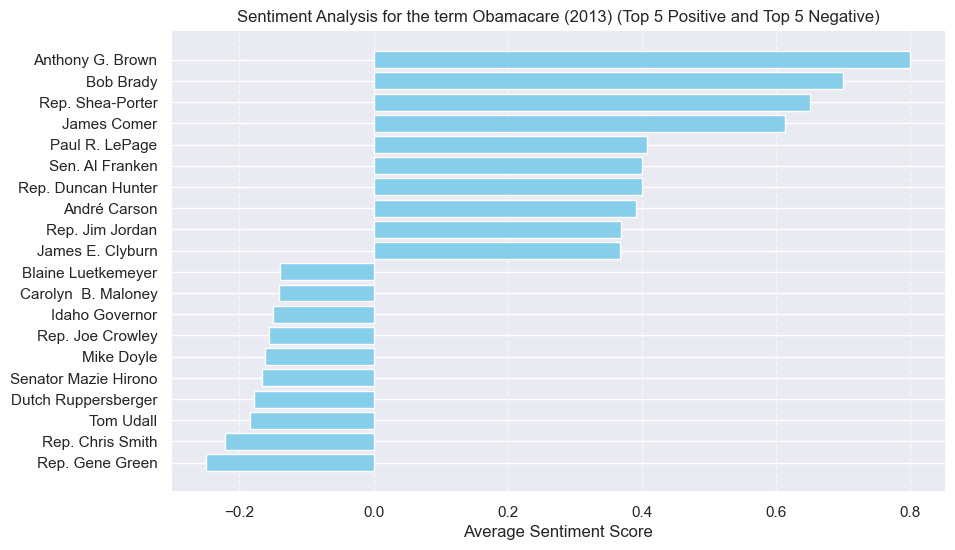

In [59]:
user_sentiments.sort_values(by='Tweet Sentiment', inplace=True)

# Select the top 5 most positive and top 5 most negative cases
top_5_positive = user_sentiments.tail(10)
top_5_negative = user_sentiments.head(10)

# Concatenate the two DataFrames
selected_users = pd.concat([top_5_negative, top_5_positive])

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(selected_users['Name'], selected_users['Tweet Sentiment'], color='skyblue')
plt.xlabel('Average Sentiment Score')
plt.title('Sentiment Analysis for the term Obamacare (2013) (Top 5 Positive and Top 5 Negative)')
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

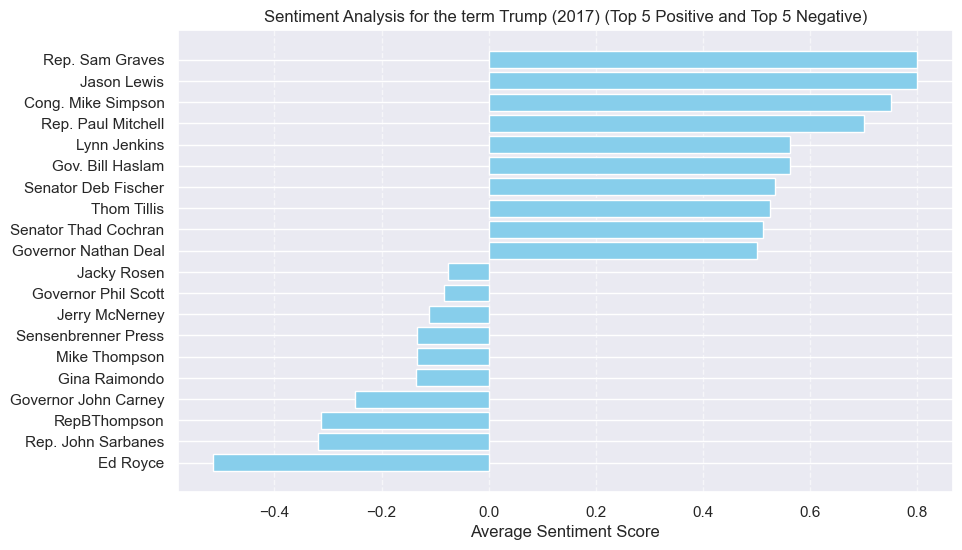

In [60]:
user_sentiments2.sort_values(by='Tweet Sentiment', inplace=True)

# Select the top 5 most positive and top 5 most negative cases
top_5_positive = user_sentiments2.tail(10)
top_5_negative = user_sentiments2.head(10)

# Concatenate the two DataFrames
selected_users = pd.concat([top_5_negative, top_5_positive])

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(selected_users['Name'], selected_users['Tweet Sentiment'], color='skyblue')
plt.xlabel('Average Sentiment Score')
plt.title('Sentiment Analysis for the term Trump (2017) (Top 5 Positive and Top 5 Negative)')
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

### Takeaway:
We see that for the 2013 sentiment analysis for the term Obamacare, our implementation gave us mixed results in terms of republicans vs democrats. One would expect sentiment analysis results to reflect users voting along party lines. In other words, since Obamacare/ACA was a democratic President's policy, one would expect positive sentiment from Democrats and negative sentiment from Republicans. However, based on our results, this does not seem to be the case. There could be a few reasons for this:
1. Our model/algorithm is too simple and we need to use a stronger algorithm to perform analysis.
2. Obamacare was a divisive topic with no clear sentiment along party lines
3. Our data is inadequate

However, for the Trump analysis during 2017, we notice predictable results. ie: Republicans have a positive sentiment towards President Trump, meanwhile the opposition (Democrats) have a negative sentiment towards the President. This might indicate that the textblob implementation we used is useful at least partially, and that Obamacare was indeed a divisive topic. However, this is just a theory and we should still consider using a stronger implementation of sentiment analysis on the data to confirm this theory.

## Directed Network Graph of Twitter Interactions

This directed graph visually represents interactions between Twitter users based on their replies to each other. Each node in the graph represents a Twitter user, and directed edges between nodes indicate instances where one user has replied to another user's tweet. The graph has been filtered to exclude self-replies, resulting in a network that highlights meaningful interactions.

We are sampling around 60 nodes as if we graph all nodes the graph will be indecipherable. The visual representation provides insights into the structure of conversations on Twitter, emphasizing users who actively engage with each other and the overall patterns of communication within the sampled dataset.

In [85]:
import networkx as nx
import random

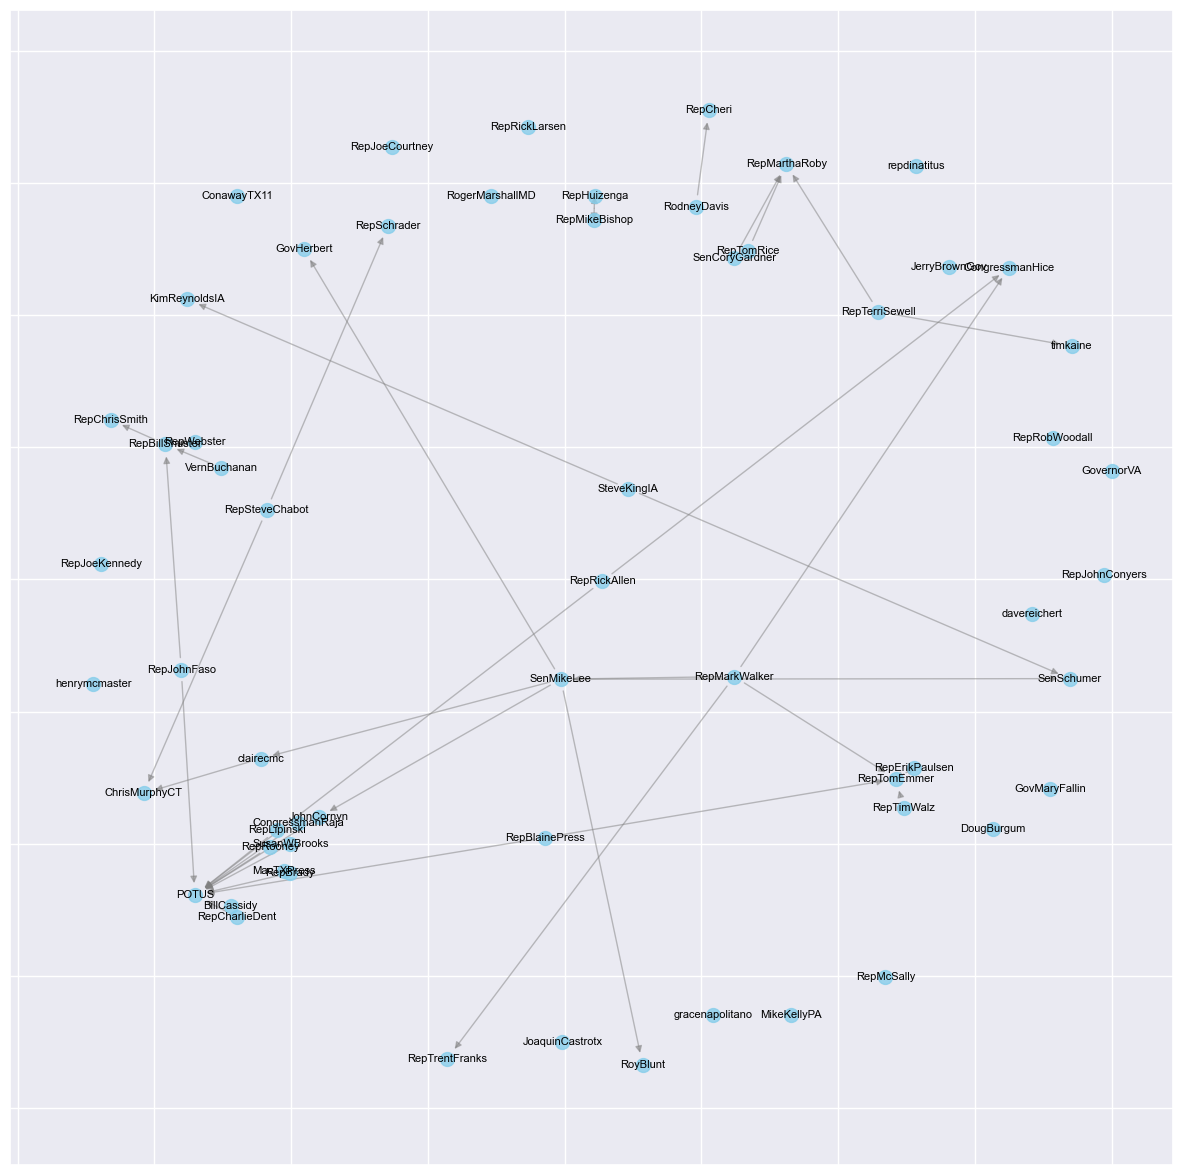

In [88]:
#Map user ids to screen name
user_mapping = dict(zip(users_df['screen_name'], users_df['id']))

# Create a directed graph
G = nx.DiGraph()

# Iterate through teach tweet
for index, row in tweets_df.iterrows():
    tweet_id = row['tweet_id']
    user_screen_name = row['screen_name']
    in_reply_to_screen_name = row['in_reply_to_screen_name']

    # Check if there is a reply, the screen_name exists in the mapping, and it's not a reply to itself
    if pd.notnull(in_reply_to_screen_name) and in_reply_to_screen_name in user_mapping and in_reply_to_screen_name != user_screen_name:
        user_id = user_mapping[user_screen_name]
        in_reply_to_user_id = user_mapping[in_reply_to_screen_name]
        G.add_edge(user_id, in_reply_to_user_id, tweet_id=tweet_id)

# Subsample nodes
num_nodes_to_display = 60
nodes_list = list(G.nodes())
sampled_nodes = random.sample(nodes_list, k=num_nodes_to_display)
H = G.subgraph(sampled_nodes)

# Draw the graph
pos = nx.spring_layout(H, seed=42)  # Seed for reproducibility
labels = {node: users_df.loc[users_df['id'] == node, 'screen_name'].values[0] for node in H.nodes()}

plt.figure(figsize=(15, 15))  # Adjust figure size

# Draw nodes and edges
nx.draw_networkx_nodes(H, pos, node_size=100, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(H, pos, width=1.0, edge_color='gray', alpha=0.5)
nx.draw_networkx_labels(H, pos, labels, font_size=8, font_color='black')

# Show the plot
plt.show()

### Takeaway:
Using such graphs, Lobbyists4America can derive relations between different congress members that share relationships, and present this data to their clients, which tells the clients which congress people work well with each other and which sub network of users to target for lobbying.

In [89]:
con.commit()
con.close()

# Conclusion:
Based on the takeaways thus far, the following can be recommended to Lobbyists4America based on the data and our Analysis.
1. Older accounts tend to have more followers than newer accounts. Representatives that have older twitter accounts but are still active politically tend to be good candidates to lobby as they gain a significant social media following over their years of service. Furthermore, if these accounts are placed in various lists by twitter users, their likelihood of having significant number of followers increases significantly.
2. Accounts that tweet a lot have more followers than accounts that tweet little. It is advisable that Lobbyists4America targets Congress members who have a very active social media presence in terms of activity.
3. Lobbyists4America can couple twitter users with clients that match industries that the users have a positive sentiment on. The more clearly an issue is divided along party lines, the wider is the network of democrats or republicans the client can cover.
4. Lobbyists4America can discover this network by creating network graphs of congresspeople that interact with each other. 

# Improvement Suggestions:
This is how this analysis can be improved further.
1. By using tools like pyspark or databricks, initial data cleaning, exploration, as well as SQL querying can be expeditiously faster.
2. We can think of a better data model for our SQL tables and create a better ERD.
3. We can use more modern or more sophisticated libraries or ML models to derive better/stronger relationships between twitter users and twitter activity.